# Setup
Group Relative Policy Optimization (GRPO) using TRL

In [ ]:
# Derived from : https://huggingface.co/learn/llm-course/en/chapter12/5
import torch
from datasets import load_dataset, load_from_disk
from peft import LoraConfig, get_peft_model
from transformers import AutoModelForCausalLM, AutoTokenizer
from trl import GRPOConfig, GRPOTrainer

# Dataset prep

In [ ]:
dataset = load_from_disk("/mimer/NOBACKUP/Datasets/LLM/huggingface/datasets/mlabonne___smoltldr_GRPO")
print(dataset)

# Load model

In [ ]:
model_name = "/mimer/NOBACKUP/Datasets/LLM/huggingface/hub/models--HuggingFaceTB--SmolLM2-135M-Instruct/snapshots/12fd25f77366fa6b3b4b768ec3050bf629380bac/"
new_model_name = "SmolLM2-llmworkshop-GRPO"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="sdpa",
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Adding LoRA

In [ ]:
# Load LoRA
lora_config = LoraConfig(
    task_type="CAUSAL_LM",
    r=16,
    lora_alpha=32,
    target_modules="all-linear",
)
model = get_peft_model(model, lora_config)
print(model.print_trainable_parameters())

# Reward Function

This function punishes our model to generate responses longer than `ideal_length`

In [ ]:
# Reward function
ideal_length = 50


def reward_len(completions, **kwargs):
    return [-abs(ideal_length - len(completion)) for completion in completions]

# Training configuration

In [ ]:
# Training arguments
training_args = GRPOConfig(
    output_dir=f"./{new_model_name}",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=2,
    max_prompt_length=512,
    max_completion_length=96,
    num_generations=8,
    optim="adamw_torch",
    num_train_epochs=1,
    bf16=True,
    remove_unused_columns=False,
    logging_steps=1,
)

In [ ]:
# Trainer
trainer = GRPOTrainer(
    model=model,
    reward_funcs=[reward_len],
    args=training_args,
    train_dataset=dataset["train"],
)

# Train model
trainer.train()

Expected Training logs:

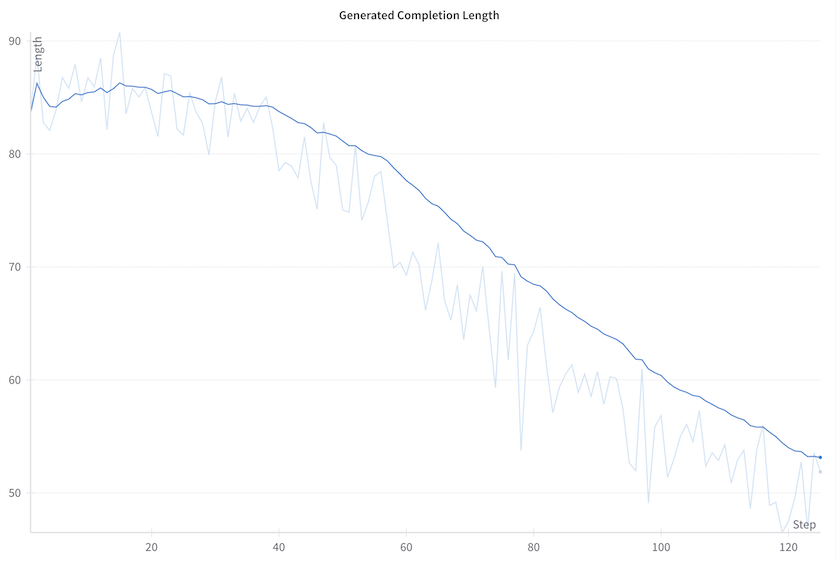
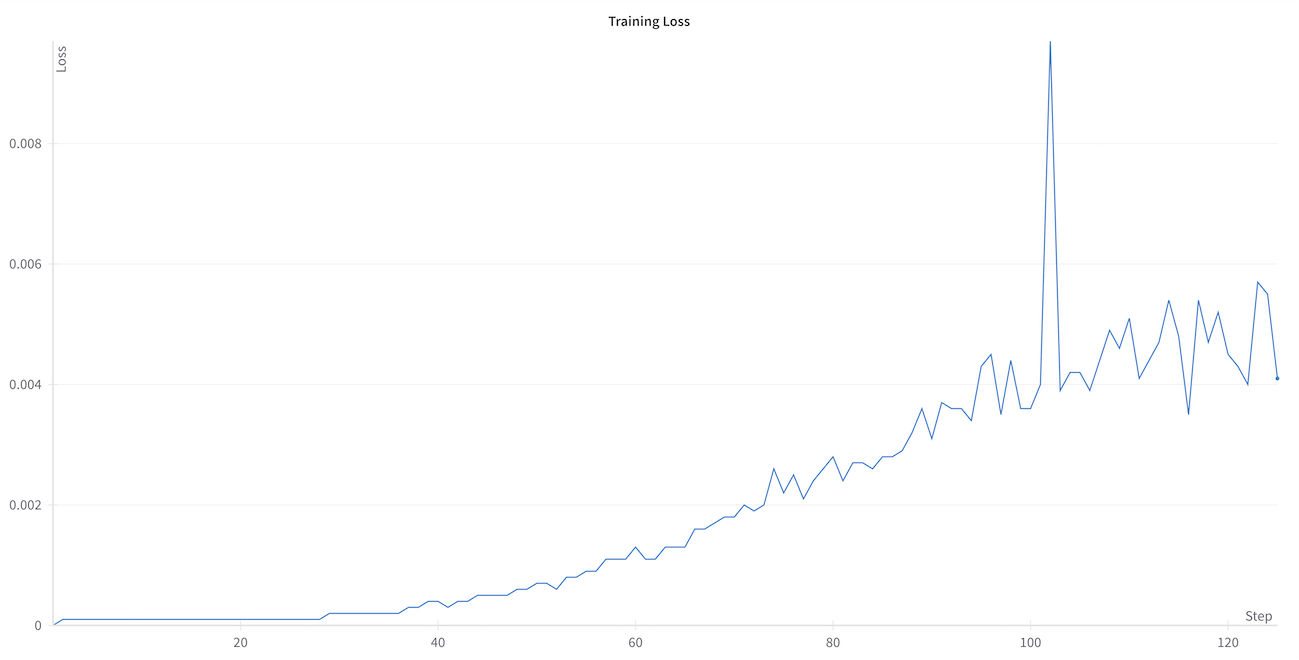

# Testing model

In [ ]:
prompt = """
# A long document about the Cat

The cat (Felis catus), also referred to as the domestic cat or house cat, is a small 
domesticated carnivorous mammal. It is the only domesticated species of the family Felidae.
Advances in archaeology and genetics have shown that the domestication of the cat occurred
in the Near East around 7500 BC. It is commonly kept as a pet and farm cat, but also ranges
freely as a feral cat avoiding human contact. It is valued by humans for companionship and
its ability to kill vermin. Its retractable claws are adapted to killing small prey species
such as mice and rats. It has a strong, flexible body, quick reflexes, and sharp teeth,
and its night vision and sense of smell are well developed. It is a social species,
but a solitary hunter and a crepuscular predator. Cat communication includes
vocalizations—including meowing, purring, trilling, hissing, growling, and grunting—as
well as body language. It can hear sounds too faint or too high in frequency for human ears,
such as those made by small mammals. It secretes and perceives pheromones.
"""

messages = [
    {"role": "user", "content": prompt},
]

In [ ]:
# Generate text
from transformers import pipeline
new_model_name = "SmolLM2-llmworkshop-GRPO"
generator = pipeline("text-generation", model=f"./{new_model_name}")

## Or use the model and tokenizer we defined earlier
# generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

generate_kwargs = {
    "max_new_tokens": 256,
    "do_sample": True,
    "temperature": 0.5,
    "min_p": 0.1,
}

generated_text = generator(messages, generate_kwargs=generate_kwargs)

print(generated_text)